### 1. Imports

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import gym
import numpy as np
from stable_baselines3 import PPO, A2C, DQN
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import json
import jsbeautifier
from datetime import datetime

In [2]:
# Import classes
from rl_environment import Environment

### 2. Parameter Selection

#### Parameters for Simulation

In [3]:
number_of_regional_warehouses = 2
max_inventory_amount_regional_warehouses = 100
max_inventory_amount_central_warehouse = 200
customer_demand_per_step = [3,5]  # List needs one entry per regional warehouse 
simulation_length = 80
lead_time = 3
shipment_amount = [15]  # Regarding regional warehouses
with_manufacturer = True
cw_shipment_amount = 30  # Regarding central warehouse
manufacturer_prod_capacity_per_step = 20
shipment_var_cost_per_unit = 0.01
shipment_fixed_cost = .15  # Reward penalty
rw_inventory_holding_cost_multiplier = 1 # Standard = 1; Can be lowered; Not higher that 1
rw_inventory_holding_cost_drop_off = .5 # Amout of drop off; Standard = 1; Lowering usefull, if large demand & shipping amount
cw_inventory_holding_cost_multiplier = .5
cw_inventory_holding_cost_drop_off  = .2
demand_fluctuation = 1
lead_time_fluctuation = 0
customer_priorities = [1, 1, 1] # List needs one entry per regional warehouse customer
use_advanced_demand_simulation = True # Simulated demand curves & integrated demand forcasting in observation space
demand_curve_length_multiplier = 1 # Standard = 1

#### Parameters for Agent Training

In [4]:
algorithm = "DQN"  # "PPO", "A2C" or "DQN"
training_steps = 300000

print("-> Equals to " + str(int(training_steps/simulation_length)) + " training episodes")

-> Equals to 3750 training episodes


###### Parameters for Logging File

In [5]:
create_logfile = True
logfile_location = "./logfiles" # Can be partial or full path. Empty string for current directory

### 3. Environment Creation

###### Determine if chosen algorithm needs discrete action space

In [6]:
algorithms_that_need_single_action_value = ["DQN"]

if algorithm.upper() in algorithms_that_need_single_action_value:
    use_single_value_action_space = True
else:
    use_single_value_action_space = False

#### Creating Environment

In [7]:
env = Environment(number_of_regional_wh = number_of_regional_warehouses, 
                  rw_inventory_limit = max_inventory_amount_regional_warehouses, 
                  cw_inventory_limit = max_inventory_amount_central_warehouse,
                  demand = customer_demand_per_step,
                  sim_length = simulation_length,
                  lead_time = lead_time,
                  shipment_amount = shipment_amount,
                  manufacturer = with_manufacturer,
                  cw_shipment_amount = cw_shipment_amount,
                  mf_prod_capacity = manufacturer_prod_capacity_per_step,
                  shipment_var_cost_per_unit = shipment_var_cost_per_unit,
                  shipment_fixed_cost = shipment_fixed_cost,
                  inventory_holding_cost_multiplier = rw_inventory_holding_cost_multiplier,
                  cw_inventory_holding_cost_multiplier = cw_inventory_holding_cost_multiplier,
                  demand_fluctuation = demand_fluctuation,
                  lead_time_fluctuation = lead_time_fluctuation,
                  use_single_value_action_space = use_single_value_action_space,
                  customer_priorities = customer_priorities,
                  rw_inventory_holding_cost_drop_off = rw_inventory_holding_cost_drop_off,
                  cw_inventory_holding_cost_drop_off = cw_inventory_holding_cost_drop_off,
                  use_advanced_demand_simulation = use_advanced_demand_simulation,
                  demand_curve_length_multiplier = demand_curve_length_multiplier
                 )

env.print_environment_information()

Simulation created with the following parameters:
________________________________________________________________________________
Simulation | Round 1
-------------------
-> Active shipments:
No active shipments

-> Warehouses:
central_warehouse ; Inventory: 66
regional_warehouse_1 ; ID: 1 ; Inventory: 33 ; Demand: 3 ; Priority: 1.0 ; Lost sales: 0
regional_warehouse_2 ; ID: 2 ; Inventory: 33 ; Demand: 5 ; Priority: 1.0 ; Lost sales: 0

-> Production plant:
manufacturer ; Production per step: 20 ; Inventory: 100
________________________________________________________________________________
Environment Information
-----------------------
-> Gym spaces:
Observation space: Dict(cw_amount_in_transit:Discrete(91), cw_inventory:Discrete(201), cw_next_arrival:Discrete(4), cw_shipment:Discrete(2), next_arrival:MultiDiscrete([4 4]), rw_amount_in_transit:MultiDiscrete([46 46]), rw_inventories:MultiDiscrete([101 101]), shipments:MultiDiscrete([2 2]))
Action space: Discrete(8)
Starting state: {

###### Initiate Logfile

In [8]:
if create_logfile:
    parameter_dict = {"number_of_regional_warehouses" : number_of_regional_warehouses,
                      "rw_inventory_limit" : max_inventory_amount_regional_warehouses,
                      "cw_inventory_limit" : max_inventory_amount_central_warehouse, "demand" : customer_demand_per_step,
                      "sim_length" : simulation_length, "lead_time" : lead_time, "shipment_amount" : shipment_amount,
                      "manufacturer" : with_manufacturer, "cw_shipment_amount" : cw_shipment_amount,
                      "mf_prod_capacity" : manufacturer_prod_capacity_per_step, "customer_priorities" : customer_priorities,
                      "shipment_var_cost_per_unit" : shipment_var_cost_per_unit, "shipment_fixed_cost" : shipment_fixed_cost,
                      "inventory_holding_cost_multiplier" : rw_inventory_holding_cost_multiplier,
                      "cw_inventory_holding_cost_multiplier" : cw_inventory_holding_cost_multiplier,
                      "demand_fluctuation" : demand_fluctuation, "lead_time_fluctuation" : lead_time_fluctuation,
                      "use_single_value_action_space" : use_single_value_action_space,
                      "rw_inventory_cost_drop_off" : rw_inventory_holding_cost_drop_off,
                      "cw_inventory_cost_drop_off" : cw_inventory_holding_cost_drop_off
                     }
    
    algorithm_dict = {"rl_model": algorithm, "num_of_training_steps": training_steps}
    json_dict = {"simulation_parameters":parameter_dict, "rl_model_training": algorithm_dict}

### 3. RL model training

###### Model Selection
PPO (Proximal Policy Optimization)
https://openai.com/blog/openai-baselines-ppo/

A2C
https://openai.com/blog/baselines-acktr-a2c/

DQN
https://openai.com/blog/openai-baselines-dqn/

In [9]:
# Choose algorithm based on user decision
if algorithm.upper() == "PPO":
    trained_model = PPO("MultiInputPolicy", env, verbose=1)
elif algorithm.upper() == "A2C":
    trained_model = A2C("MultiInputPolicy", env, verbose=1)
elif algorithm.upper() == "DQN":
    trained_model = DQN("MultiInputPolicy", env, verbose=1)
else:
    print("Model not found")
    exit()

# Start model training
trained_model.learn(total_timesteps=training_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.66    |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1335     |
|    time_elapsed     | 0        |
|    total_timesteps  | 320      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.38    |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1596     |
|    time_elapsed     | 0        |
|    total_timesteps  | 640      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.53  

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.56    |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 1825     |
|    time_elapsed     | 4        |
|    total_timesteps  | 7360     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.56    |
|    exploration_rate | 0.757    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 1829     |
|    time_elapsed     | 4        |
|    total_timesteps  | 7680     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.5     |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 1895     |
|    time_elapsed     | 7        |
|    total_timesteps  | 14400    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.53    |
|    exploration_rate | 0.534    |
| time/               |          |
|    episodes         | 184      |
|    fps              | 1892     |
|    time_elapsed     | 7        |
|    total_timesteps  | 14720    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.54    |
|    exploration_rate | 0.524    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.41    |
|    exploration_rate | 0.321    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 1946     |
|    time_elapsed     | 11       |
|    total_timesteps  | 21440    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.44    |
|    exploration_rate | 0.311    |
| time/               |          |
|    episodes         | 272      |
|    fps              | 1950     |
|    time_elapsed     | 11       |
|    total_timesteps  | 21760    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.43    |
|    exploration_rate | 0.301    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.4     |
|    exploration_rate | 0.0981   |
| time/               |          |
|    episodes         | 356      |
|    fps              | 1955     |
|    time_elapsed     | 14       |
|    total_timesteps  | 28480    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.44    |
|    exploration_rate | 0.088    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 1959     |
|    time_elapsed     | 14       |
|    total_timesteps  | 28800    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.44    |
|    exploration_rate | 0.0779   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.57    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 1950     |
|    time_elapsed     | 18       |
|    total_timesteps  | 35520    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 448      |
|    fps              | 1955     |
|    time_elapsed     | 18       |
|    total_timesteps  | 35840    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.61    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.39    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 1916     |
|    time_elapsed     | 22       |
|    total_timesteps  | 42560    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.38    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 1905     |
|    time_elapsed     | 22       |
|    total_timesteps  | 42880    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.36    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.29    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 620      |
|    fps              | 1925     |
|    time_elapsed     | 25       |
|    total_timesteps  | 49600    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.28    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 624      |
|    fps              | 1926     |
|    time_elapsed     | 25       |
|    total_timesteps  | 49920    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -5.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -13.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 688      |
|    fps              | 907      |
|    time_elapsed     | 60       |
|    total_timesteps  | 55040    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00104  |
|    n_updates        | 1259     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 692      |
|    fps              | 887      |
|    time_elapsed     | 62       |
|    total_timesteps  | 55360    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00221  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -15.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 752      |
|    fps              | 590      |
|    time_elapsed     | 101      |
|    total_timesteps  | 60160    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0153   |
|    n_updates        | 2539     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 756      |
|    fps              | 584      |
|    time_elapsed     | 103      |
|    total_timesteps  | 60480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00305  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -17.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 816      |
|    fps              | 502      |
|    time_elapsed     | 129      |
|    total_timesteps  | 65280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00133  |
|    n_updates        | 3819     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -17.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 820      |
|    fps              | 496      |
|    time_elapsed     | 132      |
|    total_timesteps  | 65600    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0013   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 880      |
|    fps              | 422      |
|    time_elapsed     | 166      |
|    total_timesteps  | 70400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0014   |
|    n_updates        | 5099     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 884      |
|    fps              | 417      |
|    time_elapsed     | 169      |
|    total_timesteps  | 70720    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00929  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 944      |
|    fps              | 370      |
|    time_elapsed     | 203      |
|    total_timesteps  | 75520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00308  |
|    n_updates        | 6379     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -9.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 948      |
|    fps              | 368      |
|    time_elapsed     | 205      |
|    total_timesteps  | 75840    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00549  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -8.42    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1008     |
|    fps              | 348      |
|    time_elapsed     | 231      |
|    total_timesteps  | 80640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00408  |
|    n_updates        | 7659     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -8.02    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1012     |
|    fps              | 346      |
|    time_elapsed     | 233      |
|    total_timesteps  | 80960    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00336  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.74    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1072     |
|    fps              | 329      |
|    time_elapsed     | 259      |
|    total_timesteps  | 85760    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0141   |
|    n_updates        | 8939     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -4.56    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1076     |
|    fps              | 328      |
|    time_elapsed     | 262      |
|    total_timesteps  | 86080    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00315  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -2.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1136     |
|    fps              | 312      |
|    time_elapsed     | 290      |
|    total_timesteps  | 90880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00333  |
|    n_updates        | 10219    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -2.77    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1140     |
|    fps              | 312      |
|    time_elapsed     | 292      |
|    total_timesteps  | 91200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00822  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -0.334   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1200     |
|    fps              | 300      |
|    time_elapsed     | 319      |
|    total_timesteps  | 96000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00418  |
|    n_updates        | 11499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -0.182   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1204     |
|    fps              | 299      |
|    time_elapsed     | 321      |
|    total_timesteps  | 96320    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00182  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1264     |
|    fps              | 289      |
|    time_elapsed     | 349      |
|    total_timesteps  | 101120   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0344   |
|    n_updates        | 12779    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1268     |
|    fps              | 287      |
|    time_elapsed     | 352      |
|    total_timesteps  | 101440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0113   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 3.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1328     |
|    fps              | 277      |
|    time_elapsed     | 383      |
|    total_timesteps  | 106240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00915  |
|    n_updates        | 14059    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 3.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1332     |
|    fps              | 276      |
|    time_elapsed     | 385      |
|    total_timesteps  | 106560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00237  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 3.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1392     |
|    fps              | 271      |
|    time_elapsed     | 409      |
|    total_timesteps  | 111360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0122   |
|    n_updates        | 15339    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 3.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1396     |
|    fps              | 271      |
|    time_elapsed     | 411      |
|    total_timesteps  | 111680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00596  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 0.551    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1456     |
|    fps              | 266      |
|    time_elapsed     | 436      |
|    total_timesteps  | 116480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0117   |
|    n_updates        | 16619    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 0.385    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1460     |
|    fps              | 266      |
|    time_elapsed     | 438      |
|    total_timesteps  | 116800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00289  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -0.705   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1520     |
|    fps              | 262      |
|    time_elapsed     | 463      |
|    total_timesteps  | 121600   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0226   |
|    n_updates        | 17899    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -0.804   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1524     |
|    fps              | 262      |
|    time_elapsed     | 465      |
|    total_timesteps  | 121920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00785  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -0.338   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1584     |
|    fps              | 256      |
|    time_elapsed     | 493      |
|    total_timesteps  | 126720   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0052   |
|    n_updates        | 19179    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -0.211   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1588     |
|    fps              | 256      |
|    time_elapsed     | 495      |
|    total_timesteps  | 127040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00637  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -0.256   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1648     |
|    fps              | 251      |
|    time_elapsed     | 524      |
|    total_timesteps  | 131840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00711  |
|    n_updates        | 20459    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -0.158   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1652     |
|    fps              | 250      |
|    time_elapsed     | 526      |
|    total_timesteps  | 132160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00773  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1712     |
|    fps              | 247      |
|    time_elapsed     | 553      |
|    total_timesteps  | 136960   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0122   |
|    n_updates        | 21739    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1716     |
|    fps              | 247      |
|    time_elapsed     | 555      |
|    total_timesteps  | 137280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00531  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 2.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1776     |
|    fps              | 244      |
|    time_elapsed     | 580      |
|    total_timesteps  | 142080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0115   |
|    n_updates        | 23019    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 2.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1780     |
|    fps              | 244      |
|    time_elapsed     | 581      |
|    total_timesteps  | 142400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00431  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 4.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1840     |
|    fps              | 242      |
|    time_elapsed     | 607      |
|    total_timesteps  | 147200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0222   |
|    n_updates        | 24299    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 4.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1844     |
|    fps              | 242      |
|    time_elapsed     | 608      |
|    total_timesteps  | 147520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00416  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 4.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1904     |
|    fps              | 239      |
|    time_elapsed     | 634      |
|    total_timesteps  | 152320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00525  |
|    n_updates        | 25579    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 4.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1908     |
|    fps              | 239      |
|    time_elapsed     | 636      |
|    total_timesteps  | 152640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00516  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 4.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1968     |
|    fps              | 237      |
|    time_elapsed     | 663      |
|    total_timesteps  | 157440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00721  |
|    n_updates        | 26859    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 4.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1972     |
|    fps              | 236      |
|    time_elapsed     | 665      |
|    total_timesteps  | 157760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00407  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 4.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2032     |
|    fps              | 235      |
|    time_elapsed     | 691      |
|    total_timesteps  | 162560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00703  |
|    n_updates        | 28139    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 4.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2036     |
|    fps              | 235      |
|    time_elapsed     | 692      |
|    total_timesteps  | 162880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.013    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 5.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2096     |
|    fps              | 231      |
|    time_elapsed     | 722      |
|    total_timesteps  | 167680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00181  |
|    n_updates        | 29419    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 5.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2100     |
|    fps              | 231      |
|    time_elapsed     | 724      |
|    total_timesteps  | 168000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00519  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 5.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2160     |
|    fps              | 229      |
|    time_elapsed     | 752      |
|    total_timesteps  | 172800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00303  |
|    n_updates        | 30699    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 5.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2164     |
|    fps              | 229      |
|    time_elapsed     | 753      |
|    total_timesteps  | 173120   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00514  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 5.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2224     |
|    fps              | 228      |
|    time_elapsed     | 778      |
|    total_timesteps  | 177920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00644  |
|    n_updates        | 31979    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 5.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2228     |
|    fps              | 228      |
|    time_elapsed     | 780      |
|    total_timesteps  | 178240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00861  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2288     |
|    fps              | 226      |
|    time_elapsed     | 808      |
|    total_timesteps  | 183040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00549  |
|    n_updates        | 33259    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 5.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2292     |
|    fps              | 226      |
|    time_elapsed     | 810      |
|    total_timesteps  | 183360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0059   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 5.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2352     |
|    fps              | 224      |
|    time_elapsed     | 838      |
|    total_timesteps  | 188160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0019   |
|    n_updates        | 34539    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 5.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2356     |
|    fps              | 224      |
|    time_elapsed     | 840      |
|    total_timesteps  | 188480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.006    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2416     |
|    fps              | 223      |
|    time_elapsed     | 866      |
|    total_timesteps  | 193280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0139   |
|    n_updates        | 35819    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2420     |
|    fps              | 223      |
|    time_elapsed     | 867      |
|    total_timesteps  | 193600   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00872  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2480     |
|    fps              | 221      |
|    time_elapsed     | 896      |
|    total_timesteps  | 198400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0029   |
|    n_updates        | 37099    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2484     |
|    fps              | 221      |
|    time_elapsed     | 898      |
|    total_timesteps  | 198720   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0185   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2544     |
|    fps              | 220      |
|    time_elapsed     | 921      |
|    total_timesteps  | 203520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00422  |
|    n_updates        | 38379    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2548     |
|    fps              | 220      |
|    time_elapsed     | 923      |
|    total_timesteps  | 203840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00946  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2608     |
|    fps              | 220      |
|    time_elapsed     | 946      |
|    total_timesteps  | 208640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00724  |
|    n_updates        | 39659    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2612     |
|    fps              | 220      |
|    time_elapsed     | 947      |
|    total_timesteps  | 208960   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00369  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2672     |
|    fps              | 220      |
|    time_elapsed     | 969      |
|    total_timesteps  | 213760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00517  |
|    n_updates        | 40939    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2676     |
|    fps              | 220      |
|    time_elapsed     | 970      |
|    total_timesteps  | 214080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00311  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2736     |
|    fps              | 220      |
|    time_elapsed     | 992      |
|    total_timesteps  | 218880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0435   |
|    n_updates        | 42219    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2740     |
|    fps              | 220      |
|    time_elapsed     | 994      |
|    total_timesteps  | 219200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.008    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2800     |
|    fps              | 220      |
|    time_elapsed     | 1014     |
|    total_timesteps  | 224000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00253  |
|    n_updates        | 43499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2804     |
|    fps              | 220      |
|    time_elapsed     | 1016     |
|    total_timesteps  | 224320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0113   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2864     |
|    fps              | 220      |
|    time_elapsed     | 1039     |
|    total_timesteps  | 229120   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00762  |
|    n_updates        | 44779    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2868     |
|    fps              | 220      |
|    time_elapsed     | 1041     |
|    total_timesteps  | 229440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00613  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2928     |
|    fps              | 218      |
|    time_elapsed     | 1069     |
|    total_timesteps  | 234240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00479  |
|    n_updates        | 46059    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2932     |
|    fps              | 218      |
|    time_elapsed     | 1071     |
|    total_timesteps  | 234560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00505  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2992     |
|    fps              | 218      |
|    time_elapsed     | 1096     |
|    total_timesteps  | 239360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0037   |
|    n_updates        | 47339    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2996     |
|    fps              | 218      |
|    time_elapsed     | 1098     |
|    total_timesteps  | 239680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0095   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3056     |
|    fps              | 217      |
|    time_elapsed     | 1121     |
|    total_timesteps  | 244480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0427   |
|    n_updates        | 48619    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3060     |
|    fps              | 217      |
|    time_elapsed     | 1123     |
|    total_timesteps  | 244800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00208  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3120     |
|    fps              | 217      |
|    time_elapsed     | 1145     |
|    total_timesteps  | 249600   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00768  |
|    n_updates        | 49899    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3124     |
|    fps              | 217      |
|    time_elapsed     | 1147     |
|    total_timesteps  | 249920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0268   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3184     |
|    fps              | 217      |
|    time_elapsed     | 1168     |
|    total_timesteps  | 254720   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00402  |
|    n_updates        | 51179    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3188     |
|    fps              | 217      |
|    time_elapsed     | 1170     |
|    total_timesteps  | 255040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0229   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3248     |
|    fps              | 217      |
|    time_elapsed     | 1193     |
|    total_timesteps  | 259840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00301  |
|    n_updates        | 52459    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3252     |
|    fps              | 217      |
|    time_elapsed     | 1194     |
|    total_timesteps  | 260160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0175   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3312     |
|    fps              | 216      |
|    time_elapsed     | 1223     |
|    total_timesteps  | 264960   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00473  |
|    n_updates        | 53739    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3316     |
|    fps              | 216      |
|    time_elapsed     | 1226     |
|    total_timesteps  | 265280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00235  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3376     |
|    fps              | 216      |
|    time_elapsed     | 1248     |
|    total_timesteps  | 270080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00614  |
|    n_updates        | 55019    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3380     |
|    fps              | 216      |
|    time_elapsed     | 1249     |
|    total_timesteps  | 270400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00237  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3440     |
|    fps              | 216      |
|    time_elapsed     | 1272     |
|    total_timesteps  | 275200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00483  |
|    n_updates        | 56299    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3444     |
|    fps              | 216      |
|    time_elapsed     | 1273     |
|    total_timesteps  | 275520   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00895  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3504     |
|    fps              | 216      |
|    time_elapsed     | 1295     |
|    total_timesteps  | 280320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0055   |
|    n_updates        | 57579    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 6.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3508     |
|    fps              | 216      |
|    time_elapsed     | 1296     |
|    total_timesteps  | 280640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0254   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3568     |
|    fps              | 216      |
|    time_elapsed     | 1318     |
|    total_timesteps  | 285440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00412  |
|    n_updates        | 58859    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3572     |
|    fps              | 216      |
|    time_elapsed     | 1320     |
|    total_timesteps  | 285760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0049   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3632     |
|    fps              | 216      |
|    time_elapsed     | 1341     |
|    total_timesteps  | 290560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00276  |
|    n_updates        | 60139    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3636     |
|    fps              | 216      |
|    time_elapsed     | 1343     |
|    total_timesteps  | 290880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0039   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3696     |
|    fps              | 216      |
|    time_elapsed     | 1365     |
|    total_timesteps  | 295680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00603  |
|    n_updates        | 61419    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | 7        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3700     |
|    fps              | 216      |
|    time_elapsed     | 1367     |
|    total_timesteps  | 296000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00748  |
|    n_updates      

###### Learning Curve

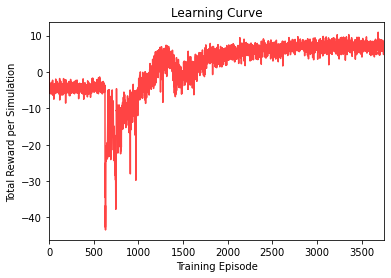

In [10]:
# Plot learning curve
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(env.total_reward, color="#FF4444")
plt.title("Learning Curve")
plt.xlim(0, len(env.total_reward))
plt.ylabel("Total Reward per Simulation")
plt.xlabel("Training Episode")
plt.show()

if create_logfile:
    rounded_rewards = []
    for reward in env.total_reward:
        rounded_rewards.append(round(reward, 2))
    json_dict["rl_model_training"]["training_rewards"] = rounded_rewards

# Print used data if True
if False:
    print("Total Rewards:", env.total_reward)

### 4. Run simulation

In [11]:
# Convert actions for graphs
def convert_to_marker_pos(action):
    return_list = []
    i = 0
    for entry in action:
        if entry != 0:
            return_list.append(i)
        i += 1
    return return_list


# Graph data
cw_inventory_level, cw_actions = [], []
inventory_levels, actions = {}, {}
manufacturer_inventory = []

for rw_id in env.simulation.get_regional_warehouses():
    inventory_levels[rw_id] = []
    actions[rw_id] = []

In [12]:
# Reset environment for simulation
state = env.reset()
done = False

# Run simulation with model
while not done:
    action, _states = trained_model.predict(state) 
    state, reward, done, info = env.step(action)
    
    # For Graph
    i = 1
    for inv in info["RW Invs:"]:
        inventory_levels[i].append(inv)
        i += 1

    i = 1
    for act in info["Action:"][0:len(env.simulation.get_regional_warehouses())]:
        actions[i].append(act)
        i += 1
    
    try:
        cw_inventory_level.append(info["CW Inv:"])
        cw_actions.append(info["Action:"][-1])
        manufacturer_inventory.append(info["Manufacturer:"])
    except:
        pass
    
    # print(env.simulation.print_state())
    for i in info:
        print(i, info[i], end=" | ")
    print()
    
print("\n", env.evaluation_parameters())

Round: 1 | RW Invs: [31, 29] | Shipments [0, 0] | Action: [0, 0, 0] | Reward: 0.05 | CW Inv: 66 | Manufacturer: 100 | 
Round: 2 | RW Invs: [29, 25] | Shipments [0, 0] | Action: [0, 0, 0] | Reward: 0.06 | CW Inv: 66 | Manufacturer: 100 | 
Round: 3 | RW Invs: [27, 21] | Shipments [0, 0] | Action: [0, 0, 0] | Reward: 0.06 | CW Inv: 66 | Manufacturer: 100 | 
Round: 4 | RW Invs: [25, 17] | Shipments [0, 1] | Action: [0, 1, 0] | Reward: -0.03 | CW Inv: 51 | Manufacturer: 100 | 
Round: 5 | RW Invs: [23, 13] | Shipments [0, 1] | Action: [0, 0, 0] | Reward: 0.09 | CW Inv: 51 | Manufacturer: 100 | 
Round: 6 | RW Invs: [21, 9] | Shipments [0, 1] | Action: [0, 0, 0] | Reward: 0.1 | CW Inv: 51 | Manufacturer: 100 | 
Round: 7 | RW Invs: [19, 20] | Shipments [1, 0] | Action: [1, 0, 0] | Reward: -0.02 | CW Inv: 36 | Manufacturer: 100 | 
Round: 8 | RW Invs: [17, 16] | Shipments [1, 1] | Action: [0, 1, 0] | Reward: 0.0 | CW Inv: 21 | Manufacturer: 100 | 
Round: 9 | RW Invs: [15, 12] | Shipments [1, 1] |

###### Inventory level graphs

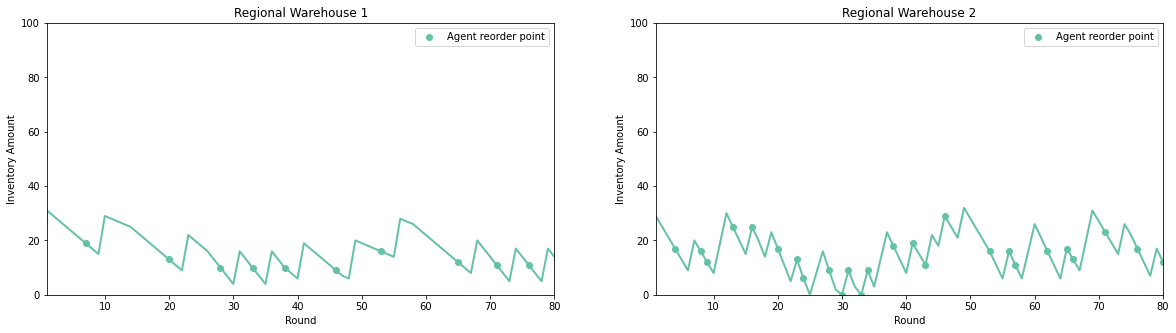

In [13]:
# Plots inventories of regional warehouses

reorder_marker = mlines.Line2D([],[], color='#66C2A5', marker='o', linestyle='None', label="Agent reorder point")
plt.rcParams["figure.figsize"] = (20, 5)

for rw_id in inventory_levels:
    plt.subplot(1, number_of_regional_warehouses, rw_id)
    plt.plot([0] + inventory_levels[rw_id], "-bo", markevery=convert_to_marker_pos([0] + actions[rw_id]), color="#66C2A5", linewidth=2)
    plt.legend(handles=[reorder_marker])
    plt.title("Regional Warehouse " + str(rw_id))
    plt.ylim(0, max_inventory_amount_regional_warehouses)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    
    # Print used data if True
    if False:
        print("RW", rw_id, "data:")
        print("Inventory:", inventory_levels[rw_id])
        print("Actions:", actions[rw_id])
        print("_"*100)

plt.show()

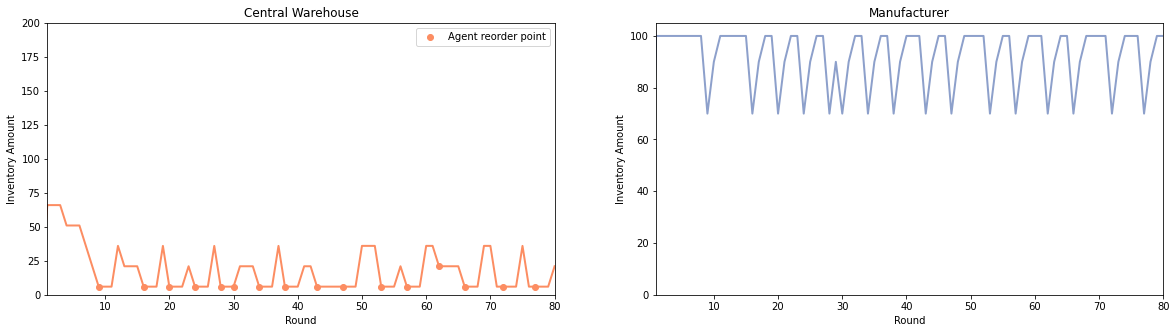

In [14]:
# Plots for CW and Manufacturer (Will only display if manufacturer is simulated)
if len(cw_inventory_level) != 0:
    # Plot for CW inventory with ordering points
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.subplot(1, 2, 1)
    reorder_marker = mlines.Line2D([],[], color='#FC8D62', marker='o', linestyle='None', label="Agent reorder point")
    plt.plot([0] + cw_inventory_level, "-bo", color="#FC8D62", markevery=convert_to_marker_pos([0] + cw_actions), linewidth=2)
    plt.legend(handles=[reorder_marker])
    plt.title("Central Warehouse")
    plt.ylim(0, max_inventory_amount_central_warehouse)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    
    # Plot for manufacturer inventory
    plt.subplot(1, 2, 2)
    plt.plot([0] + manufacturer_inventory, color="#8DA0CB", linewidth=2)
    plt.title("Manufacturer")
    plt.ylim(0, env.simulation.get_manufacturer().get_inventory_limit()+5)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    plt.show()
    
    # Print used data if True
    if False:
        print("CW Inventory:", cw_inventory_level)
        print("CW Actions:", cw_actions)
        print("Manufacturer Inventrory:", manufacturer_inventory)

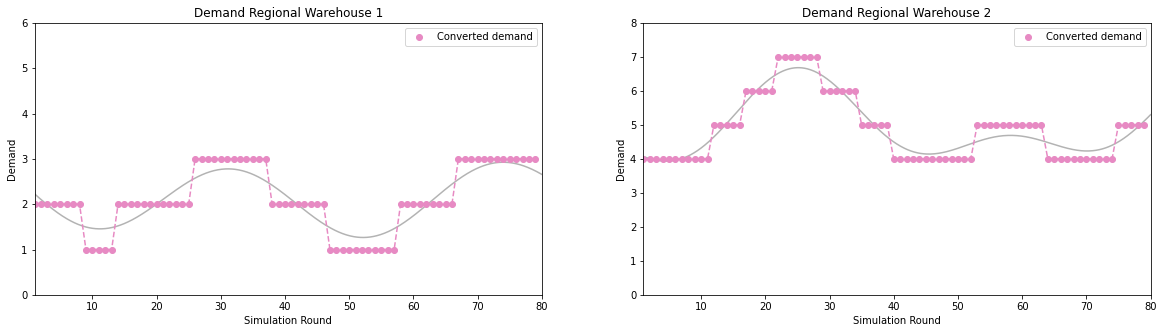

In [15]:
# Plot of Demand. Only drawn if advanced demand simulation is active
if use_advanced_demand_simulation:
    
    demand_marker = mlines.Line2D([],[], color='#E78AC3', marker='o', linestyle='None', label="Converted demand")
    plt.rcParams["figure.figsize"] = (20, 5)
    
    params = env.simulation.get_predefined_demand_parameters()
    demand_points = env.simulation.get_predefined_demands()
    
    i = 0
    for entry in demand_points:
        
        x = np.linspace(0, simulation_length, simulation_length*10)
        y = customer_demand_per_step[i] + ((params[i]["long_range_amplitude"] * np.sin(params[i]["long_range"]*x-params[i]["random_start"]))
                                          - params[i]["mid_range_amplitude"] * np.sin(params[i]["mid_range"]*x))
        
        plt.subplot(1, number_of_regional_warehouses, i+1)
        
        plt.plot(x, y, color="#B3B3B3")
        plt.plot(entry, "--o", color="#E78AC3")
        plt.title("Demand Regional Warehouse " + str(i+1))
        plt.ylim(0, customer_demand_per_step[i]+ demand_fluctuation + 2)
        plt.xlim(1, simulation_length)
        plt.legend(handles=[demand_marker])
        plt.ylabel("Demand")
        plt.xlabel("Simulation Round")
        
        i += 1
        
    plt.show()

### 5. Create Logfile

In [16]:
if create_logfile:
    simulation_run_data = {}
    simulation_run_data["stats"] = env.evaluation_parameters()
    for rw_id in inventory_levels:
        simulation_run_data["regional_warehouse_" + str(rw_id)] = {}
        simulation_run_data["regional_warehouse_" + str(rw_id)]["inventory"] = inventory_levels[rw_id]
        simulation_run_data["regional_warehouse_" + str(rw_id)]["actions"] = actions[rw_id]
        simulation_run_data["regional_warehouse_" + str(rw_id)]["demand"] = demand_points[rw_id-1]
    
    if len(cw_inventory_level) != 0:
        # Convert intc to int types
        for i in range(len(cw_inventory_level)):
            if type(cw_inventory_level[i]) == np.intc:
                cw_inventory_level[i] = cw_inventory_level[i].item()
            
        simulation_run_data["central_warehouse"] = {}
        simulation_run_data["central_warehouse"]["inventory"] = cw_inventory_level
        simulation_run_data["central_warehouse"]["actions"] = cw_actions
        
        simulation_run_data["manufacturer"] = {}
        simulation_run_data["manufacturer"]["inventory"] = manufacturer_inventory

    json_dict["simulation_run_data"] = simulation_run_data
    
    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")
    
    with open(logfile_location + "/logfile_" + dt_string + ".json", 'w') as f:
        options = jsbeautifier.default_options()
        options.indent_size = 4
        f.write(jsbeautifier.beautify(json.dumps(json_dict), options))
        print("Logfile was created")

Logfile was created
